# Exploratory Data Analysis - Financial Time Series

This notebook performs comprehensive exploratory data analysis on stock price data, including:

1. **Data Overview** - Basic statistics and data quality
2. **Trend Analysis** - Trend detection and moving averages
3. **Seasonality Analysis** - Weekly and monthly patterns
4. **Statistical Tests** - Stationarity and normality tests
5. **Autocorrelation Analysis** - ACF/PACF for ARIMA parameter selection
6. **Volume Analysis** - Volume-price relationships

## Setup and Imports

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
import config
from src.data_collection import download_stock_data
from src.data_cleaning import cleaned_data, cleaned_data_loader
from src.exploratory_analysis import (
    summary_statistics,
    returns_analysis,
    stationarity_tests,
    differencing_analysis,
    trend_detection,
    rolling_statistics,
    seasonality_decomposition,
    day_of_week_analysis,
    monthly_analysis,
    autocorrelation_analysis,
    volume_analysis,
    time_series_plot,
    trend_plot,
    decomposition_plot,
    acf_pacf_plot,
    distribution_plot,
    volume_price_plot
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.4f}'.format)

print(f"Analyzing: {config.DEFAULT_TICKER}")
print(f"Date Range: {config.START_DATE} to {config.END_DATE or 'today'}")

Analyzing: AAPL
Date Range: 2020-01-01 to today


## 1. Load Data

In [2]:
# Try to load existing cleaned data, otherwise download and clean
try:
    data = cleaned_data_loader()
    print("Loaded existing cleaned data")
except FileNotFoundError:
    print("No cleaned data found. Downloading and cleaning...")
    raw_data = download_stock_data()
    data = cleaned_data(raw_data)

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Columns: {list(data.columns)}")

No cleaned data found. Downloading and cleaning...
Data source: yfinance
Ticker: AAPL
Date range: 2020-01-01 to today
Interval: 1d
Successfully loaded 1519 data points
Date range: 2020-01-02 00:00:00-05:00 to 2026-01-16 00:00:00-05:00
Columns: Open, High, Low, Close, Volume
Data saved to: data/raw\AAPL_20200101_20260120_1d.csv

STARTING DATA CLEANING PIPELINE

Step 1: Analyzing raw data...

DATA STATISTICS REPORT

Shape: 1519 rows x 5 columns
Columns: Open, High, Low, Close, Volume

Date Range:
  Start: 2020-01-02 00:00:00-05:00
  End: 2026-01-16 00:00:00-05:00
  Total days: 2206

Missing Values:
  Open: 0 (0.00%)
  High: 0 (0.00%)
  Low: 0 (0.00%)
  Close: 0 (0.00%)
  Volume: 0 (0.00%)

Total missing values: 0
Duplicated indices: 0

Data Types:
  Open: float64
  High: float64
  Low: float64
  Close: float64
  Volume: int64

Step 2: Checking datetime index...
Removing timezone info (was America/New_York)...

Step 3: Handling duplicated indices...
No duplicated indices found.

Step 4: S

In [3]:
# Preview data
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-02,71.4766,72.5286,71.2233,72.4683,135480400
2020-01-03,71.6962,72.5238,71.5394,71.7637,146322800
2020-01-06,70.8855,72.3742,70.6345,72.3356,118387200
2020-01-07,72.3452,72.6009,71.7758,71.9953,108872000
2020-01-08,71.6986,73.4551,71.6986,73.1535,132079200
2020-01-09,74.1307,74.9003,73.8797,74.7073,170108400
2020-01-10,74.9414,75.4408,74.3744,74.8762,140644800
2020-01-13,75.1923,76.5025,75.0741,76.4759,121532000
2020-01-14,76.4132,76.6231,75.3202,75.4433,161954400


In [4]:
# Basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1519 entries, 2020-01-02 to 2026-01-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1519 non-null   float64
 1   High    1519 non-null   float64
 2   Low     1519 non-null   float64
 3   Close   1519 non-null   float64
 4   Volume  1519 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 103.5 KB


## 2. Statistical Summary

In [5]:
# Comprehensive statistics
stats = summary_statistics(data, column='Close')


STATISTICAL SUMMARY - Close

Date Range: 2020-01-02 to 2026-01-16
Trading Days: 1519 | Calendar Days: 2206

Central Tendency:
  Mean: $165.64
  Median: $164.00

Dispersion:
  Std Dev: $50.21
  Range: $231.93 ($54.26 - $286.19)
  IQR: $67.73
  CV: 30.31%

Distribution Shape:
  Skewness: 0.0998
  Kurtosis: -0.4248


In [6]:
# Standard describe for all columns
data.describe()

,Open,High,Low,Close,Volume
count,1519.0000,1519.0000,1519.0000,1519.0000,1519.0000
mean,165.4865,167.3318,163.7879,165.6395,84265497.6300
std,50.1832,50.5117,49.8730,50.2091,51282611.3395
min,55.1616,55.2632,51.4202,54.2643,17910600.0000
25%,132.0340,133.1502,130.2166,131.5636,50499550.0000
50%,164.1400,165.9066,162.7082,164.0027,70122700.0000
75%,198.5765,201.4060,196.6566,199.2946,100231200.0000
max,286.2000,288.6200,283.3000,286.1900,426510000.0000


In [7]:
# Returns analysis
returns_stats = returns_analysis(data, column='Close')


RETURNS ANALYSIS

Daily Returns:
  Mean: 0.1029%
  Std Dev: 1.9981%

Annualized Metrics:
  Return: 25.94%
  Volatility: 31.72%
  Sharpe Ratio: 0.8178

Extreme Values:
  Max Daily Gain: 15.33%
  Max Daily Loss: -12.86%

Win/Loss:
  Positive Days: 804 (53.0%)
  Negative Days: 710


## 3. Time Series Visualization

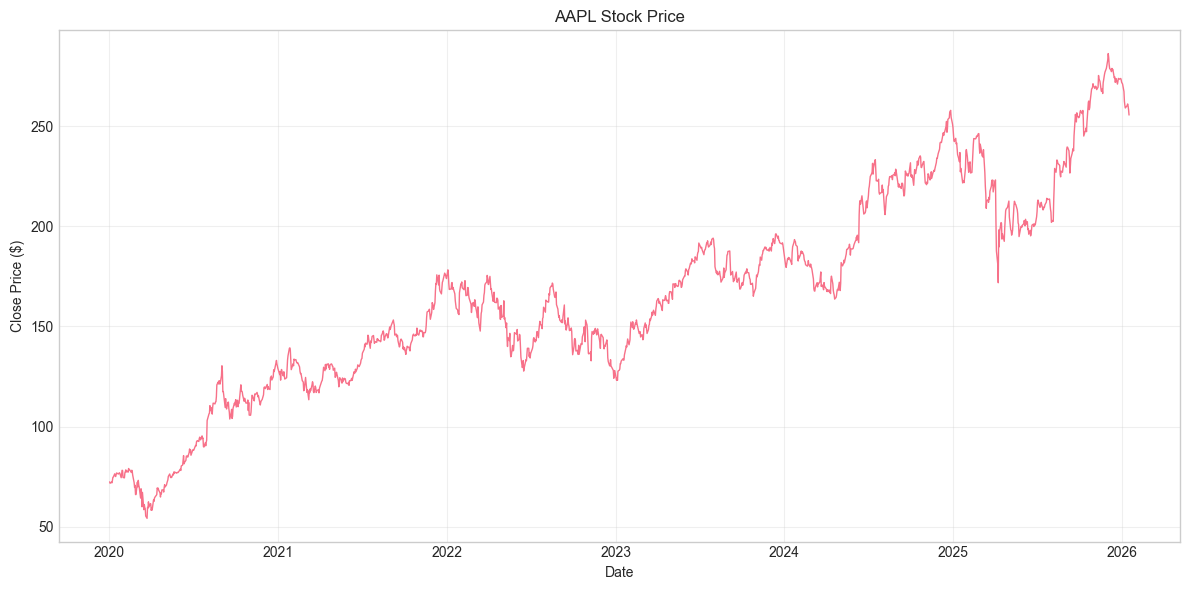

In [8]:
# Basic time series plot
fig = time_series_plot(data, column='Close', title=f'{config.DEFAULT_TICKER} Stock Price')
plt.show()

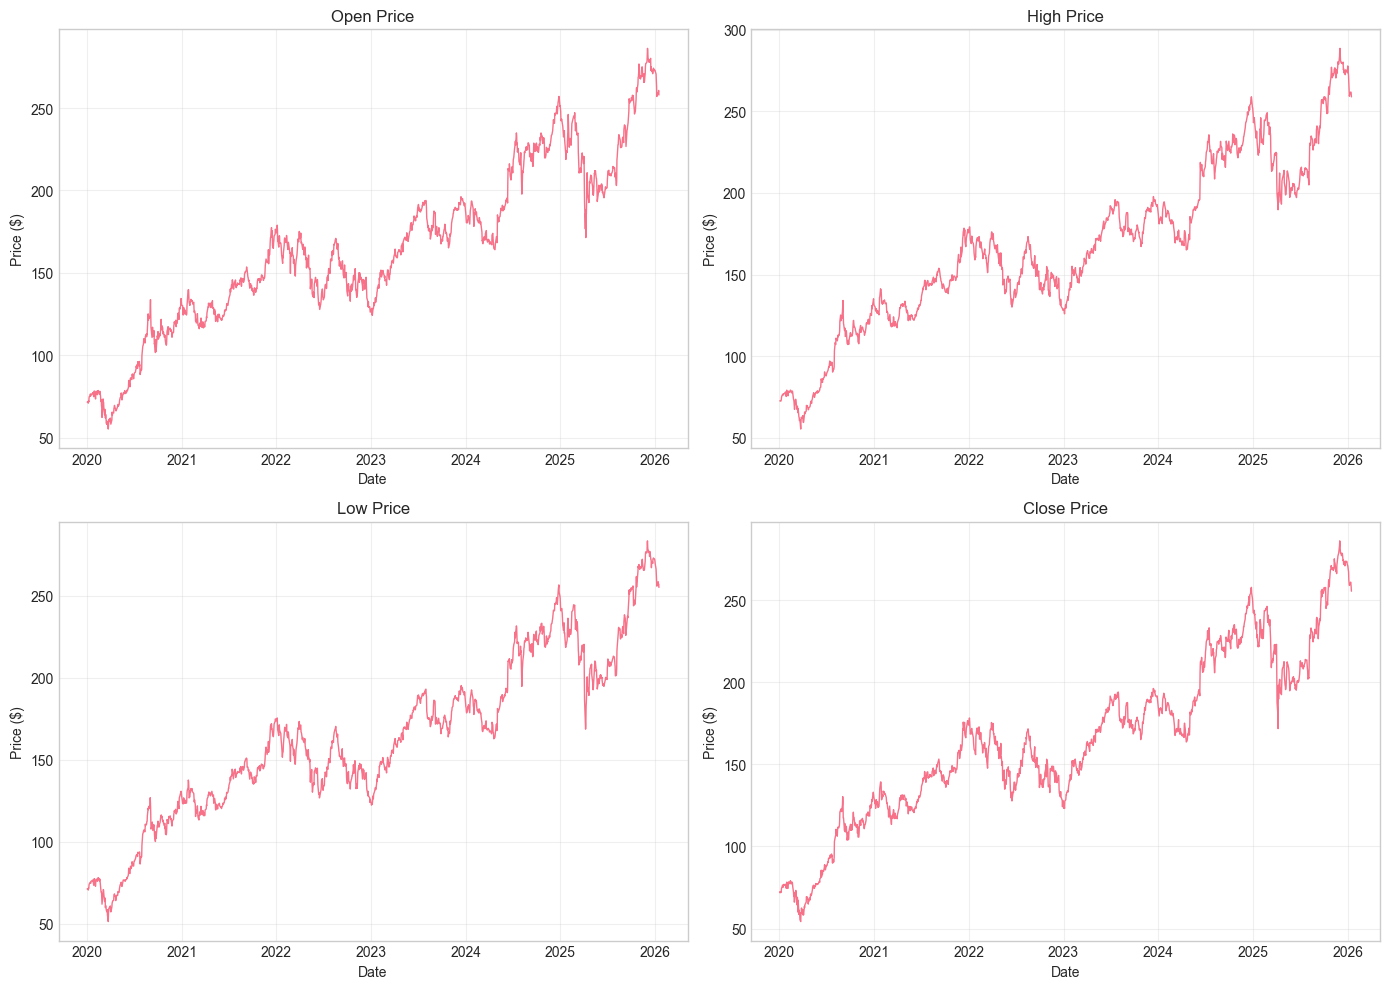

In [9]:
# OHLC overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, col in zip(axes.flat, ['Open', 'High', 'Low', 'Close']):
    ax.plot(data.index, data[col], linewidth=1)
    ax.set_title(f'{col} Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Trend Analysis

In [10]:
# Trend detection
trend_results = trend_detection(data, column='Close', windows=[20, 50, 200])


TREND ANALYSIS - Close

Overall Trend: UPWARD
  Slope: 0.1070 per day
  R-squared: 0.8738
  Trend Strength: 0.9348

Recent Trend (last 20%): UPWARD

Price Change:
  Total Change: $183.06
  Total Change %: 252.61%
  Avg Daily Change: $0.1206


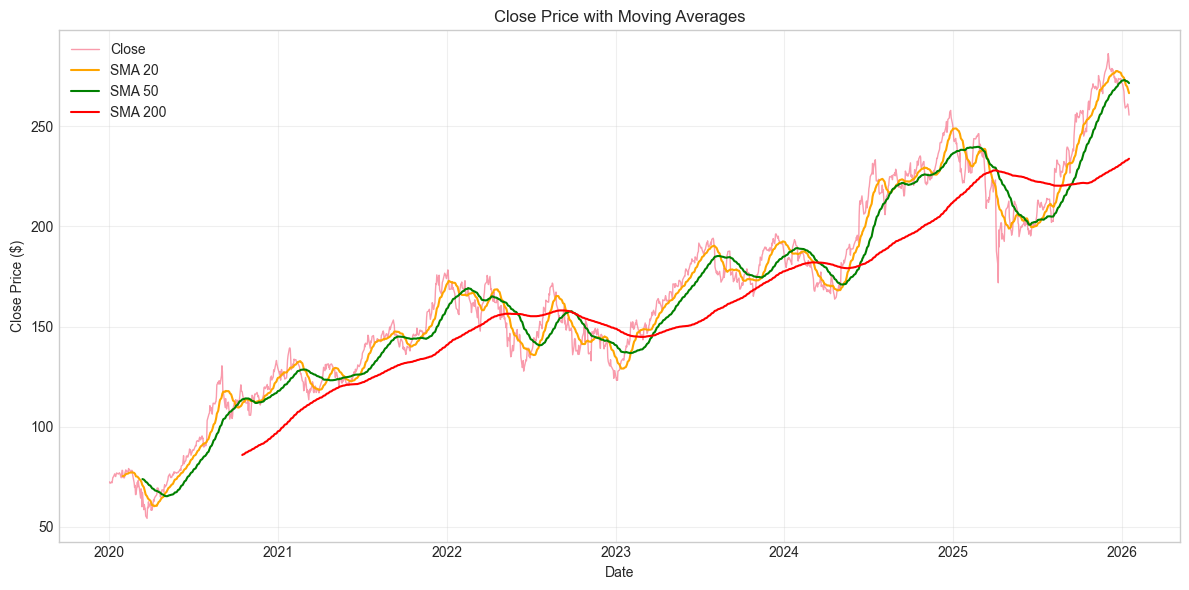

In [11]:
# Trend plot with moving averages
fig = trend_plot(data, column='Close', windows=[20, 50, 200])
plt.show()

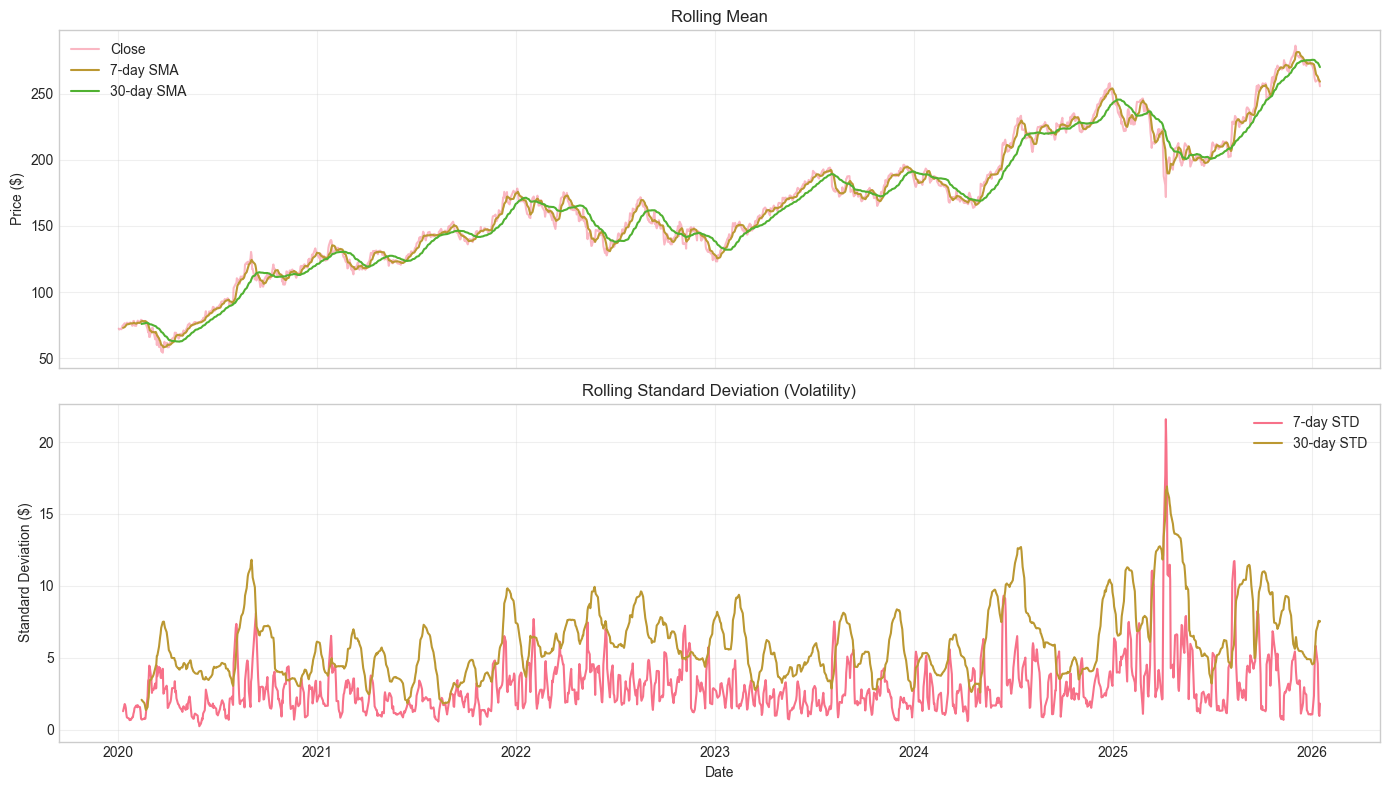

In [12]:
# Rolling statistics
rolling_stats = rolling_statistics(data, column='Close', windows=[7, 30, 60])

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Rolling mean
axes[0].plot(data.index, data['Close'], label='Close', alpha=0.5)
axes[0].plot(rolling_stats.index, rolling_stats['SMA_7'], label='7-day SMA')
axes[0].plot(rolling_stats.index, rolling_stats['SMA_30'], label='30-day SMA')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Rolling Mean')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling standard deviation
axes[1].plot(rolling_stats.index, rolling_stats['STD_7'], label='7-day STD')
axes[1].plot(rolling_stats.index, rolling_stats['STD_30'], label='30-day STD')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation ($)')
axes[1].set_title('Rolling Standard Deviation (Volatility)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Seasonality Analysis


SEASONAL DECOMPOSITION - Close

Model: ADDITIVE
Period: 5

Component Strengths:
  Trend Strength: 0.9986 (Strong)
  Seasonal Strength: 0.0020 (Weak)


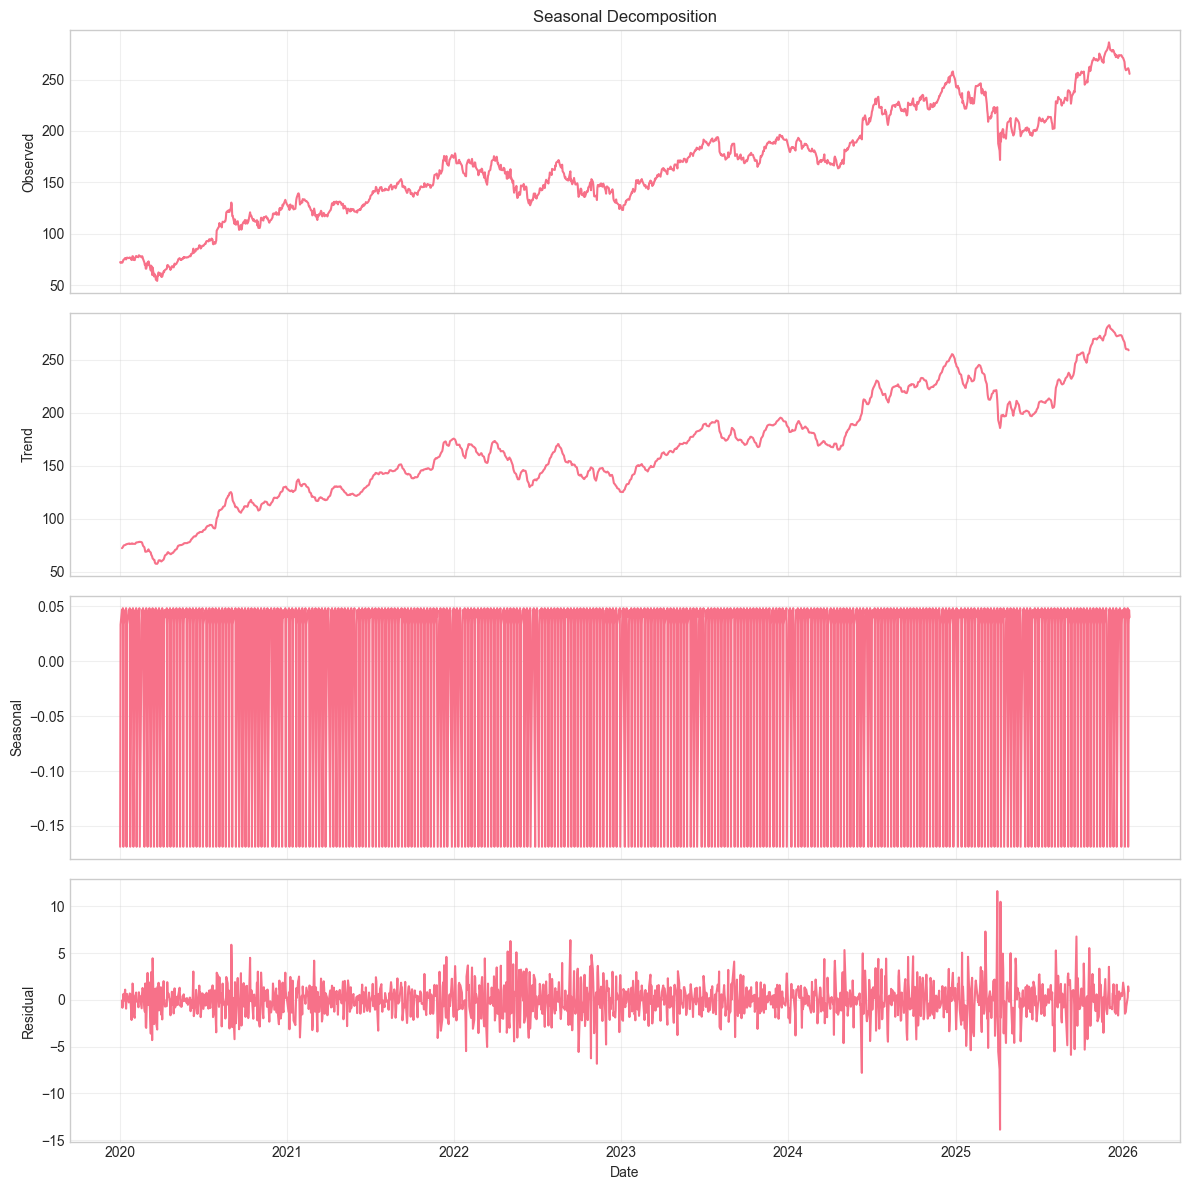

In [13]:
# Seasonal decomposition (weekly period for trading days)
try:
    seasonal_results = seasonality_decomposition(data, column='Close', period=5, model='additive')
    fig = decomposition_plot(seasonal_results)
    plt.show()
except Exception as e:
    print(f"Decomposition failed: {e}")


SEASONAL DECOMPOSITION - Close

Model: MULTIPLICATIVE
Period: 21

Component Strengths:
  Trend Strength: 1.0000 (Strong)
  Seasonal Strength: 0.0056 (Weak)


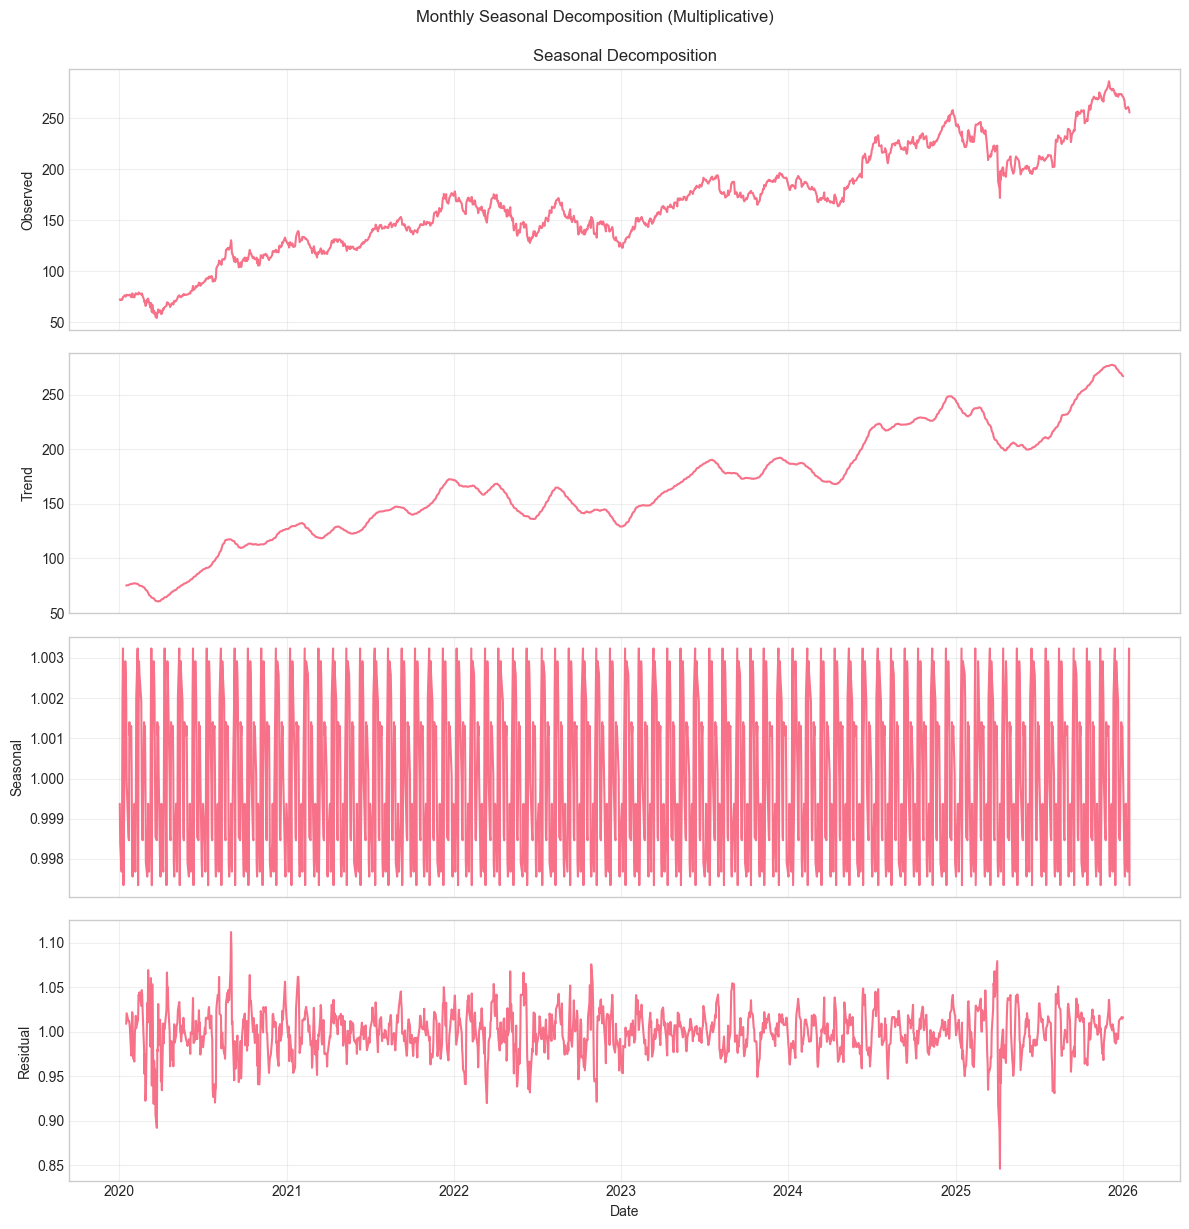

In [14]:
# Try monthly period (approximately 21 trading days)
try:
    seasonal_monthly = seasonality_decomposition(data, column='Close', period=21, model='multiplicative')
    fig = decomposition_plot(seasonal_monthly)
    plt.suptitle('Monthly Seasonal Decomposition (Multiplicative)', y=1.02)
    plt.show()
except Exception as e:
    print(f"Monthly decomposition failed: {e}")

In [15]:
# Day of week analysis
dow_results = day_of_week_analysis(data, column='Close')


DAY OF WEEK ANALYSIS

Average Returns by Day:
  Monday: +0.2423% (std: 2.1574%)
  Tuesday: +0.1615% (std: 1.8215%)
  Wednesday: +0.1216% (std: 1.8950%)
  Thursday: -0.0790% (std: 2.0474%)
  Friday: +0.0756% (std: 2.0691%)

Best Day: Monday (+0.2423%)
Worst Day: Thursday (-0.0790%)


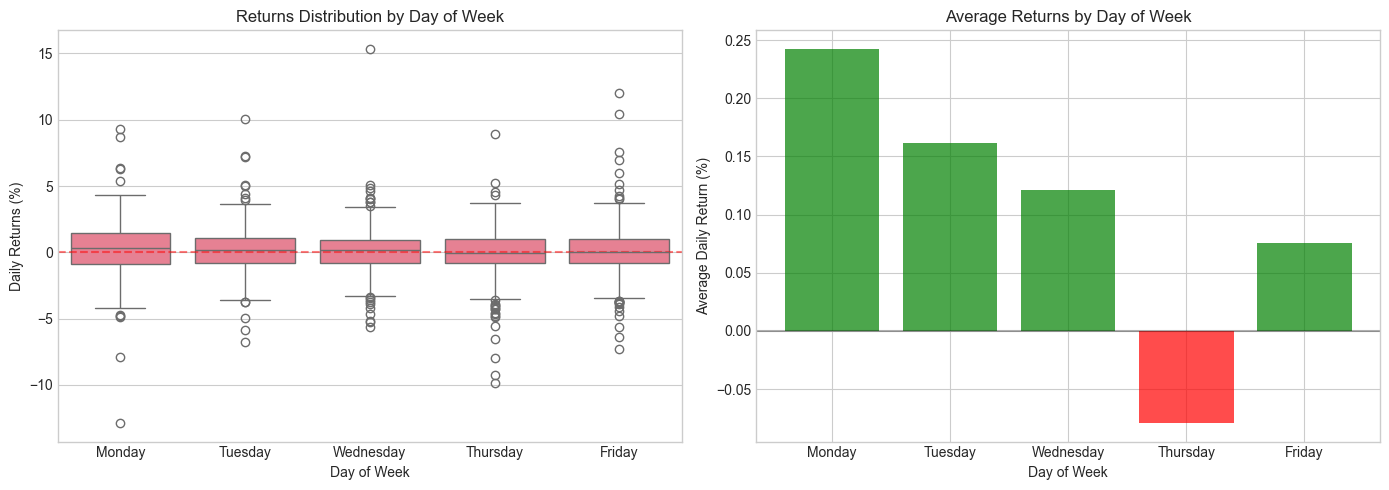

In [16]:
# Day of week visualization
df_temp = data.copy()
df_temp['returns'] = df_temp['Close'].pct_change() * 100
df_temp['day_name'] = df_temp.index.day_name()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(data=df_temp, x='day_name', y='returns', order=day_order, ax=axes[0])
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Daily Returns (%)')
axes[0].set_title('Returns Distribution by Day of Week')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Bar plot of average returns
avg_returns = df_temp.groupby('day_name')['returns'].mean().reindex(day_order)
colors = ['green' if x > 0 else 'red' for x in avg_returns]
axes[1].bar(avg_returns.index, avg_returns.values, color=colors, alpha=0.7)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Daily Return (%)')
axes[1].set_title('Average Returns by Day of Week')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Monthly analysis
monthly_results = monthly_analysis(data, column='Close')


MONTHLY ANALYSIS

Average Daily Returns by Month:
  January: -0.0221%
  February: -0.1873%
  March: +0.0220%
  April: +0.1108%
  May: +0.0865%
  June: +0.2946%
  July: +0.3804%
  August: +0.2466%
  September: -0.2121%
  October: +0.1120%
  November: +0.2991%
  December: +0.0820%

Best Month: July (+0.3804%)
Worst Month: September (-0.2121%)


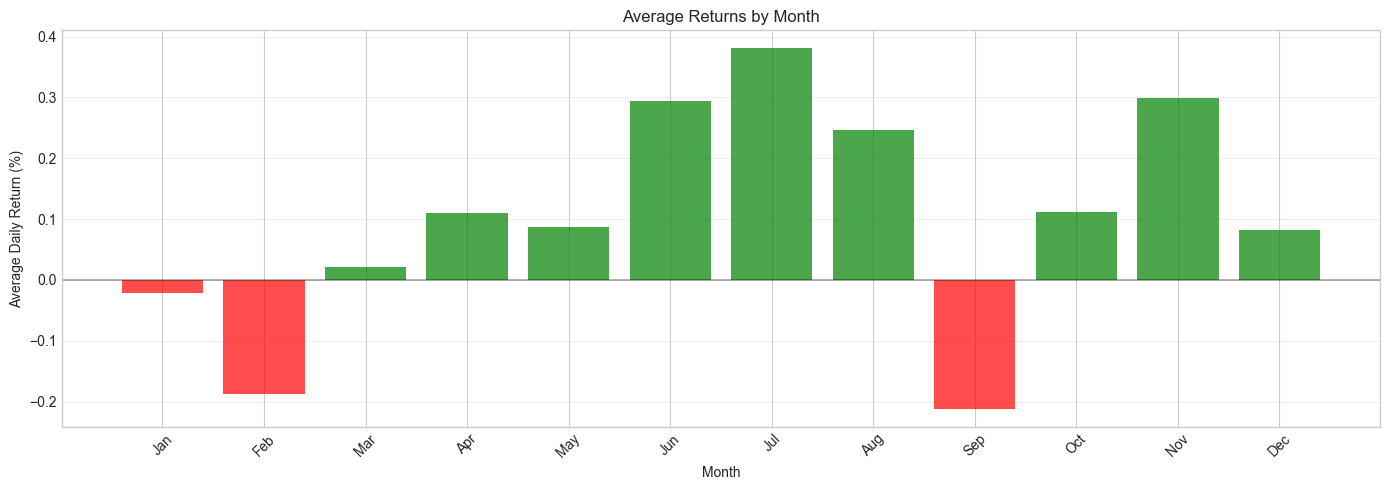

In [18]:
# Monthly visualization
df_temp['month_name'] = df_temp.index.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize=(14, 5))

avg_monthly = df_temp.groupby('month_name')['returns'].mean().reindex(month_order)
colors = ['green' if x > 0 else 'red' for x in avg_monthly]
ax.bar(range(len(avg_monthly)), avg_monthly.values, color=colors, alpha=0.7)
ax.set_xticks(range(len(avg_monthly)))
ax.set_xticklabels([m[:3] for m in avg_monthly.index], rotation=45)
ax.set_xlabel('Month')
ax.set_ylabel('Average Daily Return (%)')
ax.set_title('Average Returns by Month')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6. Stationarity Tests

In [19]:
# Stationarity tests on original series
stationarity_results = stationarity_tests(data, column='Close')


STATIONARITY TESTS - Close

Augmented Dickey-Fuller Test:
  H0: Series has unit root (non-stationary)
  Test Statistic: -1.2114
  P-Value: 0.6687
  Critical Values:
    1%: -3.4347
    5%: -2.8634
    10%: -2.5678
  Result: NON-STATIONARY (fail to reject H0)

KPSS Test:
  H0: Series is stationary
  Test Statistic: 5.1185
  P-Value: 0.0100
  Result: NON-STATIONARY

Overall Conclusion: NON-STATIONARY


c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\src\exploratory_analysis.py:133: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [20]:
# Differencing analysis to find optimal d
diff_results = differencing_analysis(data, column='Close', max_diff=2)


STATIONARITY TESTS - Close

Augmented Dickey-Fuller Test:
  H0: Series has unit root (non-stationary)
  Test Statistic: -1.2114
  P-Value: 0.6687
  Critical Values:
    1%: -3.4347
    5%: -2.8634
    10%: -2.5678
  Result: NON-STATIONARY (fail to reject H0)

KPSS Test:
  H0: Series is stationary
  Test Statistic: 5.1185
  P-Value: 0.0100
  Result: NON-STATIONARY

Overall Conclusion: NON-STATIONARY

STATIONARITY TESTS - Close

Augmented Dickey-Fuller Test:
  H0: Series has unit root (non-stationary)
  Test Statistic: -38.0837
  P-Value: 0.0000
  Critical Values:
    1%: -3.4347
    5%: -2.8634
    10%: -2.5678
  Result: STATIONARY (reject H0)

KPSS Test:
  H0: Series is stationary
  Test Statistic: 0.0284
  P-Value: 0.1000
  Result: STATIONARY

Overall Conclusion: STATIONARY

STATIONARITY TESTS - Close

Augmented Dickey-Fuller Test:
  H0: Series has unit root (non-stationary)
  Test Statistic: -7.3494
  P-Value: 0.0000
  Critical Values:
    1%: -3.4347
    5%: -2.8635
    10%: -2.567

c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\src\exploratory_analysis.py:133: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\src\exploratory_analysis.py:133: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
c:\Users\adilmusali\OneDrive - Tartu Ülikool\Desktop\time_forecast\src\exploratory_analysis.py:133: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


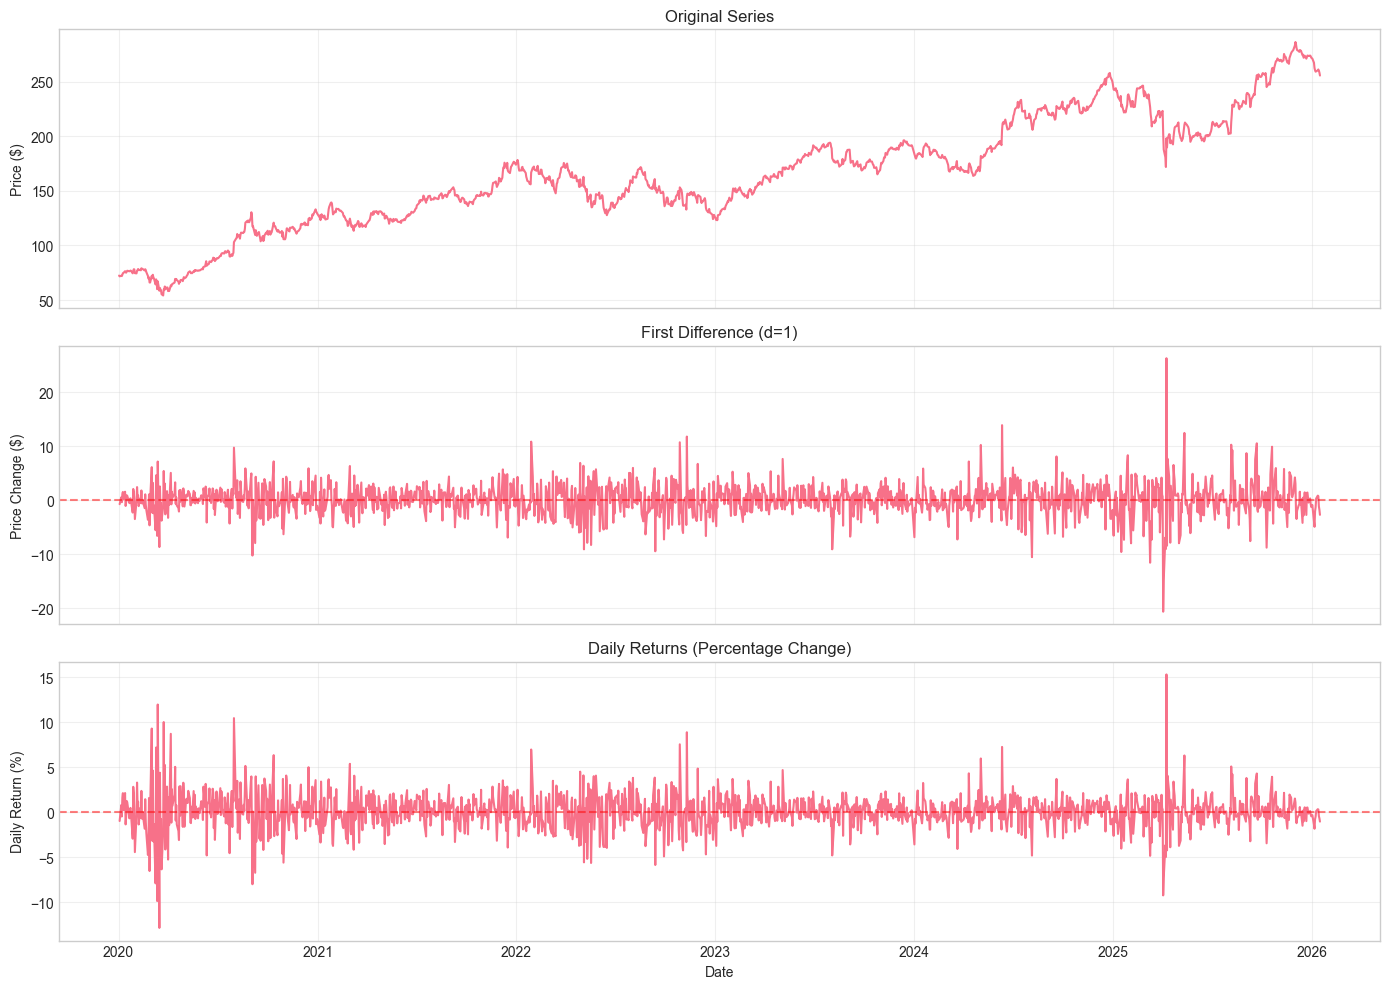

In [21]:
# Visualize original vs differenced series
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(data.index, data['Close'])
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Original Series')
axes[0].grid(True, alpha=0.3)

# First difference
diff_1 = data['Close'].diff().dropna()
axes[1].plot(diff_1.index, diff_1)
axes[1].set_ylabel('Price Change ($)')
axes[1].set_title('First Difference (d=1)')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Returns (log difference)
returns = data['Close'].pct_change().dropna() * 100
axes[2].plot(returns.index, returns)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Daily Return (%)')
axes[2].set_title('Daily Returns (Percentage Change)')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Autocorrelation Analysis

In [22]:
# ACF/PACF analysis
acf_results = autocorrelation_analysis(data, column='Close', nlags=40)


AUTOCORRELATION ANALYSIS - Close

95% Confidence Interval: +/- 0.0503

Significant ACF Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Significant PACF Lags: [1]

First 5 ACF values: ['0.9960', '0.9919', '0.9877', '0.9836', '0.9796']
First 5 PACF values: ['0.9967', '-0.0269', '-0.0191', '0.0159', '0.0197']


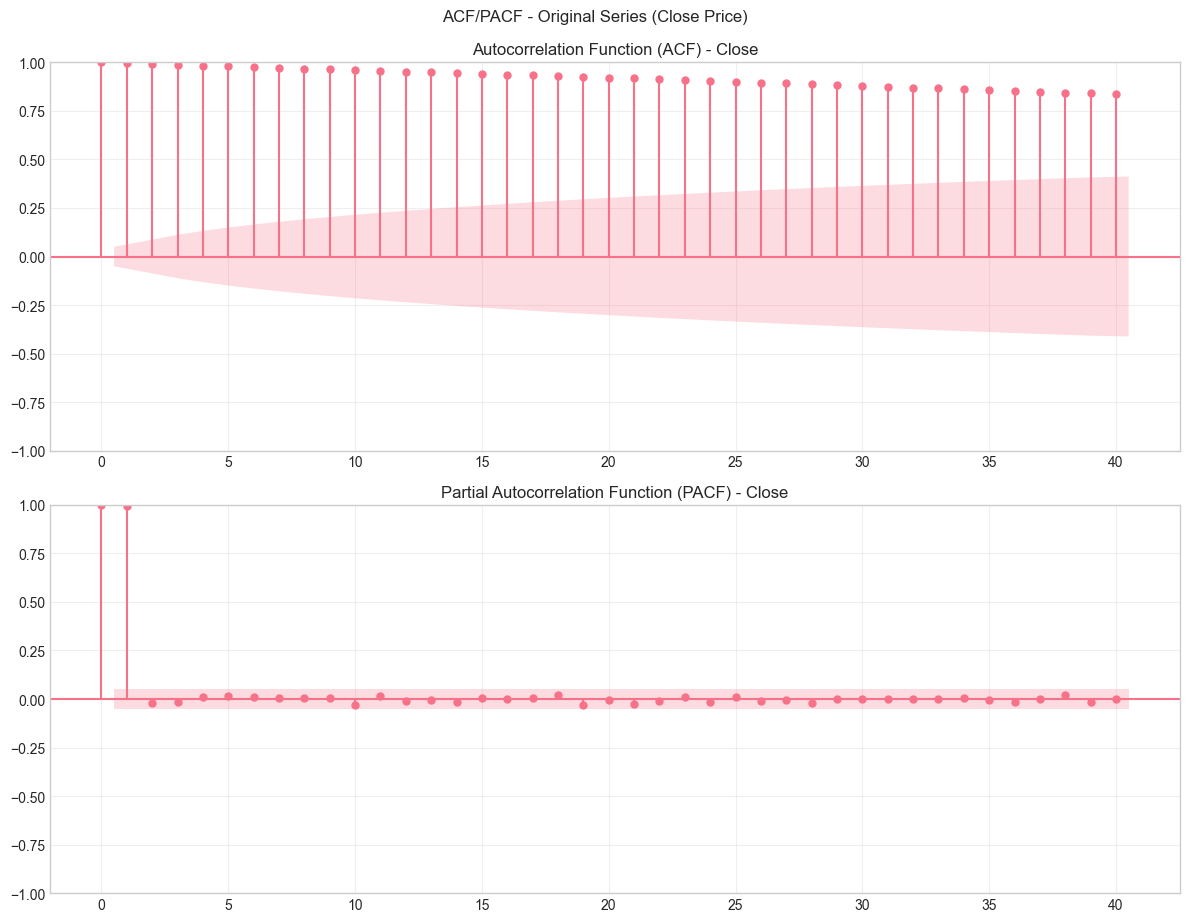

In [23]:
# ACF/PACF plots for original series
fig = acf_pacf_plot(data, column='Close', nlags=40)
plt.suptitle('ACF/PACF - Original Series (Close Price)', y=1.02)
plt.show()

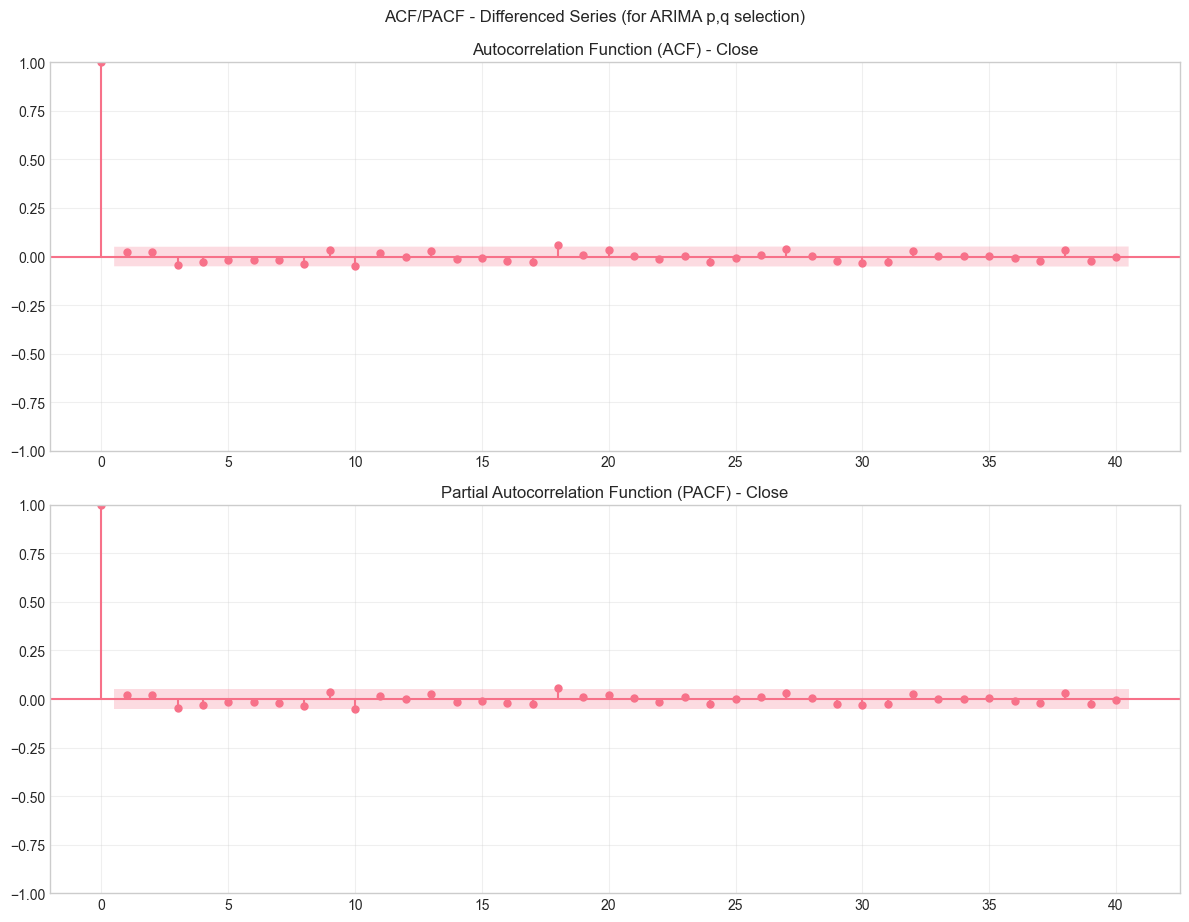

In [24]:
# ACF/PACF for differenced series (more useful for ARIMA)
diff_data = pd.DataFrame({'Close': data['Close'].diff().dropna()})
diff_data.index = data.index[1:]

fig = acf_pacf_plot(diff_data, column='Close', nlags=40)
plt.suptitle('ACF/PACF - Differenced Series (for ARIMA p,q selection)', y=1.02)
plt.show()

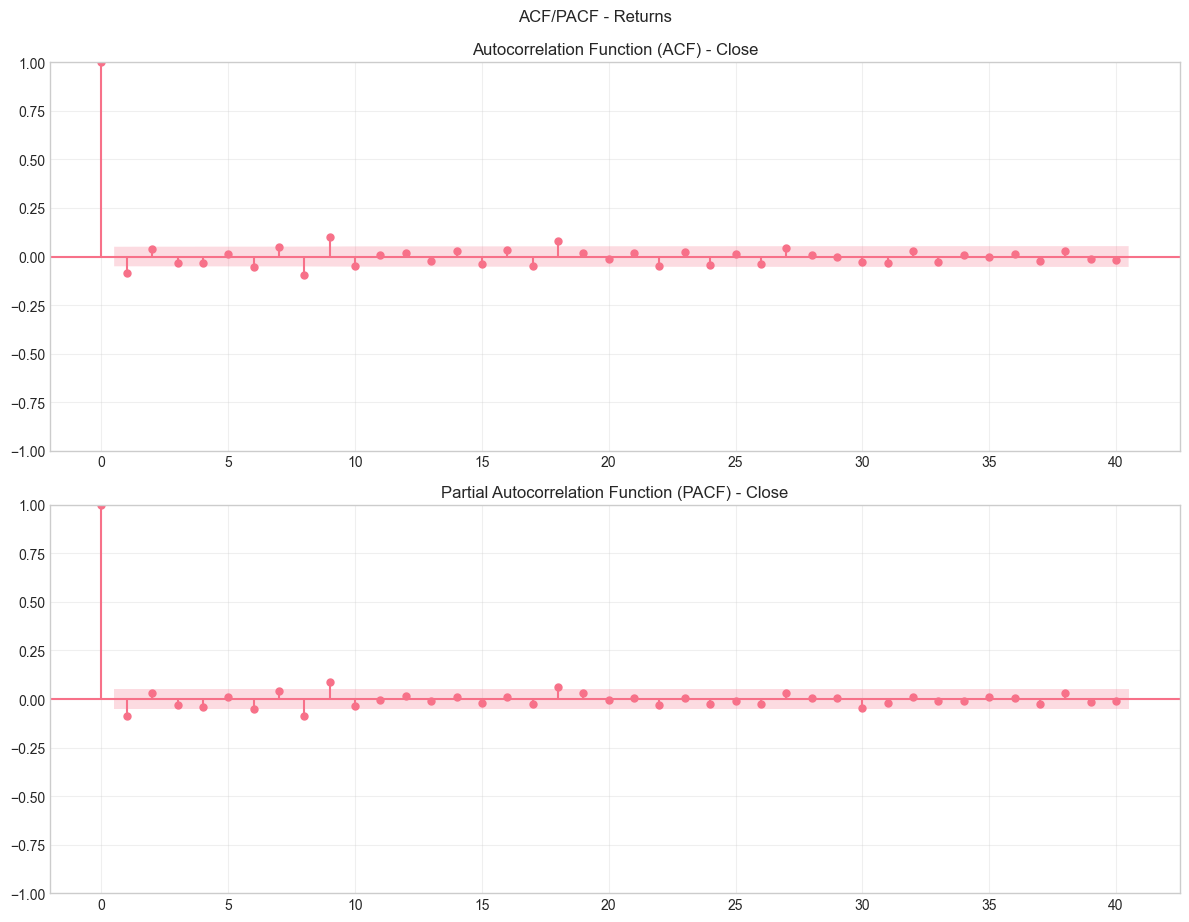

In [25]:
# ACF/PACF for returns
returns_data = pd.DataFrame({'Close': data['Close'].pct_change().dropna()})
returns_data.index = data.index[1:]

fig = acf_pacf_plot(returns_data, column='Close', nlags=40)
plt.suptitle('ACF/PACF - Returns', y=1.02)
plt.show()

## 8. Distribution Analysis

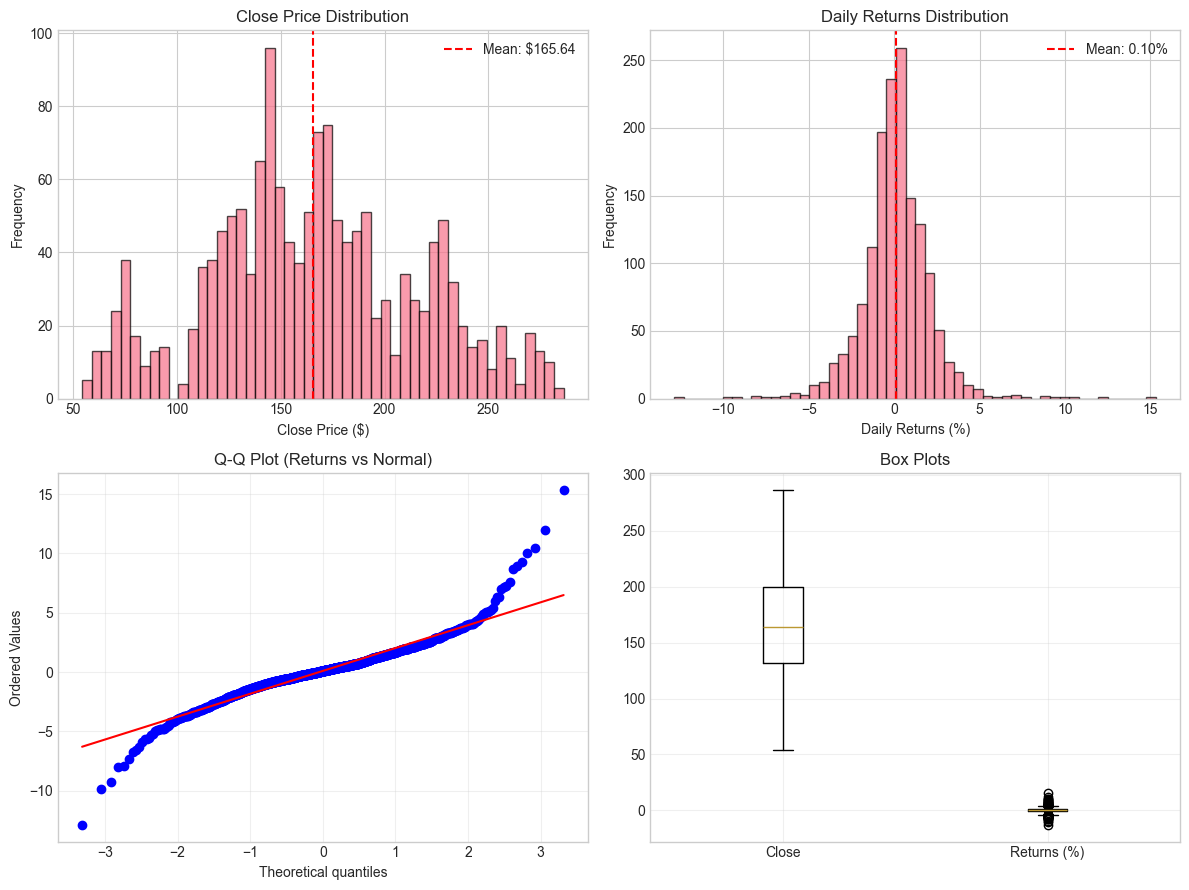

In [26]:
# Distribution plots
fig = distribution_plot(data, column='Close')
plt.show()

In [27]:
# Normality test on returns
from scipy import stats

returns = data['Close'].pct_change().dropna()

# Shapiro-Wilk test (for smaller samples)
if len(returns) <= 5000:
    shapiro_stat, shapiro_p = stats.shapiro(returns)
    print(f"Shapiro-Wilk Test:")
    print(f"  Statistic: {shapiro_stat:.4f}")
    print(f"  P-value: {shapiro_p:.4f}")
    print(f"  Result: {'Normal' if shapiro_p > 0.05 else 'Not Normal'}")

# Jarque-Bera test
jb_stat, jb_p = stats.jarque_bera(returns)
print(f"\nJarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_p:.4f}")
print(f"  Result: {'Normal' if jb_p > 0.05 else 'Not Normal'}")

# D'Agostino-Pearson test
k2_stat, k2_p = stats.normaltest(returns)
print(f"\nD'Agostino-Pearson Test:")
print(f"  Statistic: {k2_stat:.4f}")
print(f"  P-value: {k2_p:.4f}")
print(f"  Result: {'Normal' if k2_p > 0.05 else 'Not Normal'}")

Shapiro-Wilk Test:
  Statistic: 0.9291
  P-value: 0.0000
  Result: Not Normal

Jarque-Bera Test:
  Statistic: 2956.2517
  P-value: 0.0000
  Result: Not Normal

D'Agostino-Pearson Test:
  Statistic: 238.5049
  P-value: 0.0000
  Result: Not Normal


## 9. Volume Analysis

In [28]:
# Volume analysis
if 'Volume' in data.columns:
    vol_results = volume_analysis(data)
else:
    print("Volume column not available")


VOLUME ANALYSIS

Volume Statistics:
  Mean: 84,265,498
  Median: 70,122,700
  Std Dev: 51,282,611

Correlations:
  Volume-Returns (abs): 0.5282
  Volume-Price: -0.6359

Recent Activity:
  Recent Volume vs Average: 0.53x
  High Volume Days: 210 (13.8%)


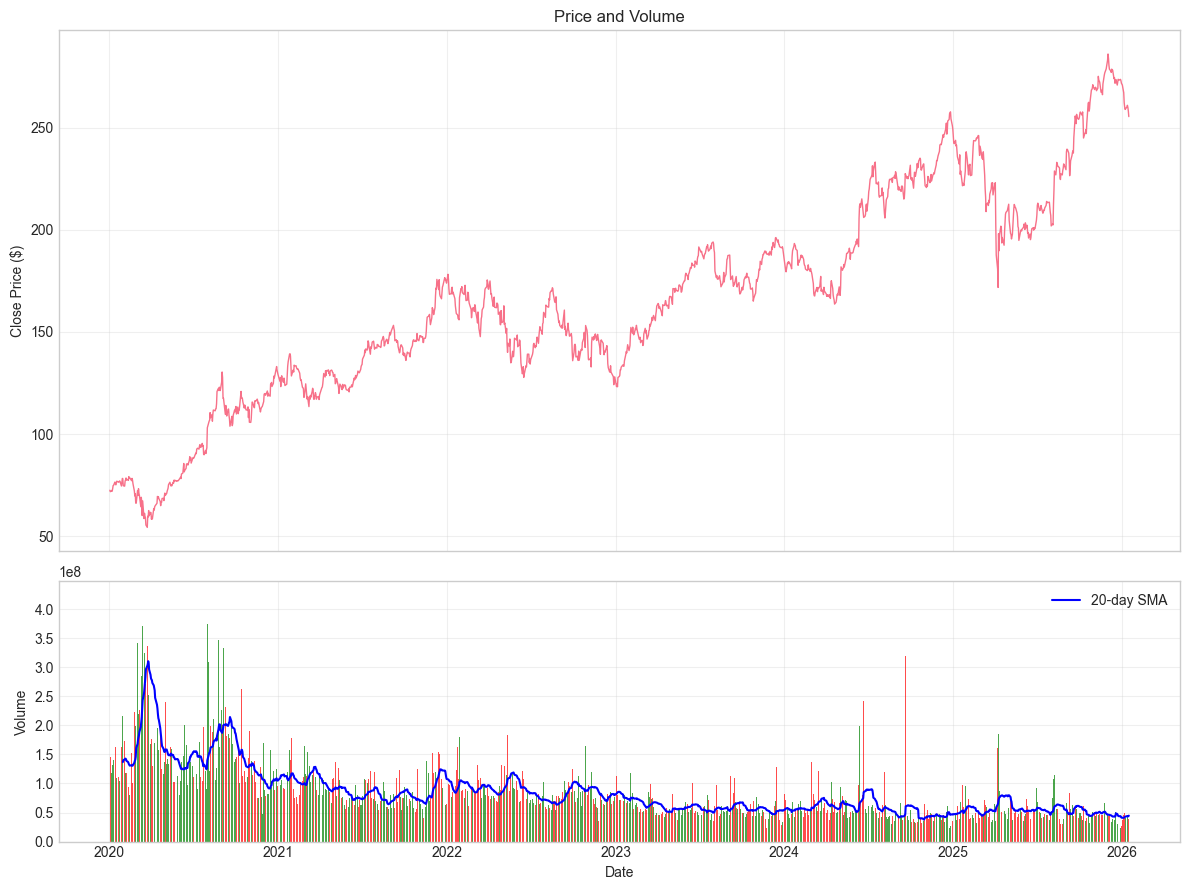

In [29]:
# Volume-price plot
if 'Volume' in data.columns:
    fig = volume_price_plot(data)
    plt.show()

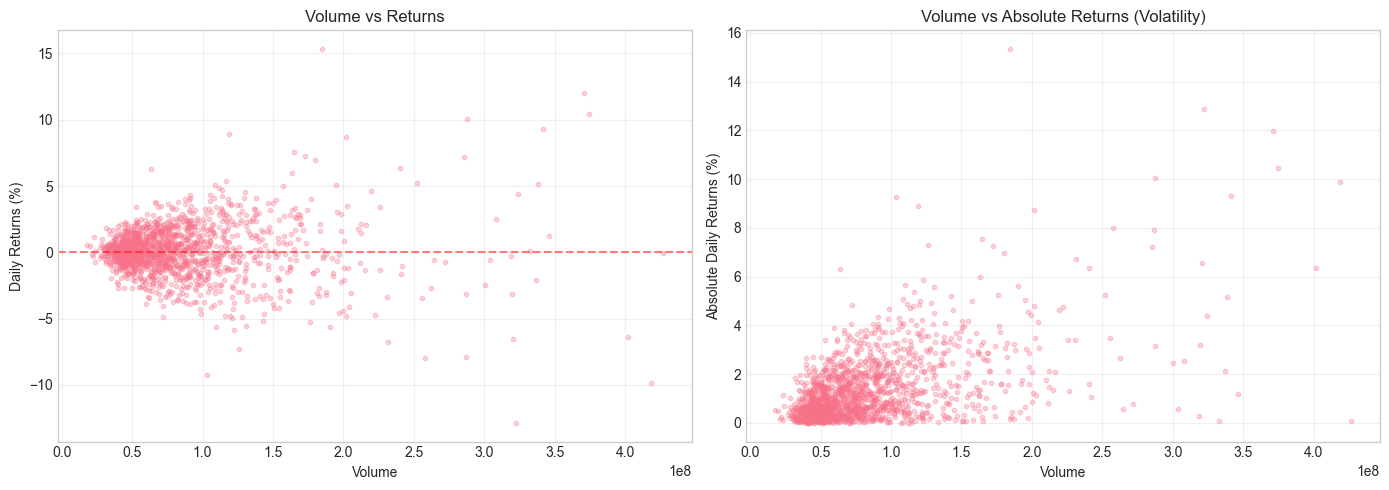

Correlation (Volume vs |Returns|): 0.5282


In [30]:
# Volume vs Returns scatter
if 'Volume' in data.columns:
    df_temp = data.copy()
    df_temp['returns'] = df_temp['Close'].pct_change() * 100
    df_temp['abs_returns'] = df_temp['returns'].abs()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Volume vs Returns
    axes[0].scatter(df_temp['Volume'], df_temp['returns'], alpha=0.3, s=10)
    axes[0].set_xlabel('Volume')
    axes[0].set_ylabel('Daily Returns (%)')
    axes[0].set_title('Volume vs Returns')
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0].grid(True, alpha=0.3)
    
    # Volume vs Absolute Returns
    axes[1].scatter(df_temp['Volume'], df_temp['abs_returns'], alpha=0.3, s=10)
    axes[1].set_xlabel('Volume')
    axes[1].set_ylabel('Absolute Daily Returns (%)')
    axes[1].set_title('Volume vs Absolute Returns (Volatility)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    corr = df_temp['Volume'].corr(df_temp['abs_returns'])
    print(f"Correlation (Volume vs |Returns|): {corr:.4f}")

## 10. Summary and Key Findings

In [31]:
print("=" * 70)
print("KEY FINDINGS SUMMARY")
print("=" * 70)

print(f"\n1. DATA OVERVIEW")
print(f"   - Ticker: {config.DEFAULT_TICKER}")
print(f"   - Period: {data.index.min().strftime('%Y-%m-%d')} to {data.index.max().strftime('%Y-%m-%d')}")
print(f"   - Trading Days: {len(data)}")
print(f"   - Price Range: ${data['Close'].min():.2f} - ${data['Close'].max():.2f}")

print(f"\n2. RETURNS")
print(f"   - Annualized Return: {returns_stats['annualized_return']:.2f}%")
print(f"   - Annualized Volatility: {returns_stats['annualized_volatility']:.2f}%")
print(f"   - Sharpe Ratio: {returns_stats['sharpe_ratio']:.4f}")

print(f"\n3. TREND")
print(f"   - Overall Trend: {trend_results['trend_direction'].upper()}")
print(f"   - Recent Trend: {trend_results['recent_trend'].upper()}")
print(f"   - Total Change: {trend_results['total_change_pct']:.2f}%")

print(f"\n4. STATIONARITY")
print(f"   - Original Series: {stationarity_results['conclusion'].upper()}")
print(f"   - Recommended Differencing (d): {diff_results['optimal_d']}")

print(f"\n5. SEASONALITY")
print(f"   - Best Day of Week: {dow_results['best_day']} ({dow_results['best_day_return']:+.4f}%)")
print(f"   - Worst Day of Week: {dow_results['worst_day']} ({dow_results['worst_day_return']:+.4f}%)")
print(f"   - Best Month: {monthly_results['best_month']} ({monthly_results['best_month_return']:+.4f}%)")
print(f"   - Worst Month: {monthly_results['worst_month']} ({monthly_results['worst_month_return']:+.4f}%)")

print(f"\n6. ARIMA PARAMETER SUGGESTIONS")
print(f"   - d (differencing): {diff_results['optimal_d']}")
print(f"   - Significant ACF lags: {acf_results['significant_acf_lags'][:5]}")
print(f"   - Significant PACF lags: {acf_results['significant_pacf_lags'][:5]}")

print("\n" + "=" * 70)

KEY FINDINGS SUMMARY

1. DATA OVERVIEW
   - Ticker: AAPL
   - Period: 2020-01-02 to 2026-01-16
   - Trading Days: 1519
   - Price Range: $54.26 - $286.19

2. RETURNS
   - Annualized Return: 25.94%
   - Annualized Volatility: 31.72%
   - Sharpe Ratio: 0.8178

3. TREND
   - Overall Trend: UPWARD
   - Recent Trend: UPWARD
   - Total Change: 252.61%

4. STATIONARITY
   - Original Series: NON-STATIONARY
   - Recommended Differencing (d): 1

5. SEASONALITY
   - Best Day of Week: Monday (+0.2423%)
   - Worst Day of Week: Thursday (-0.0790%)
   - Best Month: July (+0.3804%)
   - Worst Month: September (-0.2121%)

6. ARIMA PARAMETER SUGGESTIONS
   - d (differencing): 1
   - Significant ACF lags: [1, 2, 3, 4, 5]
   - Significant PACF lags: [1]



## Save Results

In [32]:
# Save all EDA results to a dictionary
eda_results = {
    'summary_statistics': stats,
    'returns_analysis': returns_stats,
    'trend_detection': trend_results,
    'stationarity_tests': stationarity_results,
    'differencing_analysis': diff_results,
    'day_of_week': dow_results,
    'monthly_analysis': monthly_results,
    'autocorrelation': acf_results
}

if 'Volume' in data.columns:
    eda_results['volume_analysis'] = vol_results

print("EDA results saved to 'eda_results' dictionary")
print(f"Keys: {list(eda_results.keys())}")

EDA results saved to 'eda_results' dictionary
Keys: ['summary_statistics', 'returns_analysis', 'trend_detection', 'stationarity_tests', 'differencing_analysis', 'day_of_week', 'monthly_analysis', 'autocorrelation', 'volume_analysis']
